# Section 1 - Image Set-Up

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import cv2 as cv
from PIL import Image
import imgaug.augmenters as iaa
import math
import random
from random import randint
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf

In [2]:
import Project_Functions1 as pf

In [3]:
# Create df from .pkl of cleaned image labels
df = pd.read_pickle('Labels/Clean_Images.pkl')
df["N,D,G,C,A,H,M,O"] = df["N,D,G,C,A,H,M,O"].apply(lambda x:x.tolist())
df.reset_index(inplace=True)
df = pd.concat([df, pd.DataFrame(df['N,D,G,C,A,H,M,O'].to_list(), columns = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O'])], ignore_index=False, axis=1)
df.drop(columns=['Classes', 'ID', 'N,D,G,C,A,H,M,O'], inplace=True)
df = df.astype({"N":'int', "D":'int', 'G':'int', 'C':'int', 'A':'int', 'H':'int', 'M':'int', 'O':'int',}) 
df.head()

Patient Age Patient Sex  Image_Name  \
0           69      Female  0_left.jpg   
1           57        Male  1_left.jpg   
2           66        Male  3_left.jpg   
3           53        Male  4_left.jpg   
4           50      Female  5_left.jpg   

                      Diagnostic_Keywords  N  D  G  C  A  H  M  O  
0                                cataract  0  0  0  1  0  0  0  0  
1                           normal fundus  1  0  0  0  0  0  0  0  
2                           normal fundus  1  0  0  0  0  0  0  0  
3             macular epiretinal membrane  0  0  0  0  0  0  0  1  
4  moderate non proliferative retinopathy  0  1  0  0  0  0  0  0

In [4]:
# Create list of image filepaths from df containing the 9300 images we'll use
image_filepaths = df['Image_Name'].values
image_filepaths

array(['0_left.jpg', '1_left.jpg', '3_left.jpg', ..., '4997_right.jpg',
       '4998_right.jpg', '4999_right.jpg'], dtype=object)

In [5]:
classes = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

for i in classes:
    print(f"class {i}: {df[i].sum()}")

class N: 3994
class D: 2429
class G: 421
class C: 425
class A: 403
class H: 273
class M: 369
class O: 1576


In [6]:
image_examples_filepaths = ['1_left.jpg', '5_left.jpg', '153_left.jpg','0_left.jpg', '43_left.jpg', '23_left.jpg','13_left.jpg', '7_left.jpg']
image_examples_labels = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O  (Drusen)']

In [7]:
img_size = 224
batch_size = 32

In [8]:
X_pictures = pf.image_to_array_no_background(image_examples_filepaths, 224)
X_pictures.shape

100%|██████████| 8/8 [00:00<00:00,  9.69it/s]


(8, 224, 224, 3)

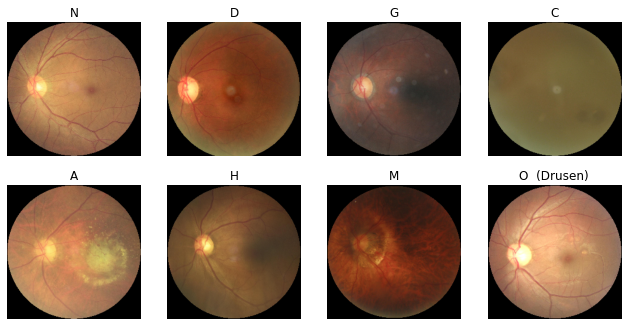

In [9]:
# 1 example per class
# create figure
fig = plt.figure(figsize=(11, 5.5))
  
# setting values to rows and column variables
rows = 2
columns = 4

for label, idx in zip(image_examples_labels, range(len(X_pictures))):
    fig.add_subplot(rows, columns, idx+1)
    
    # showing image
    plt.imshow(X_pictures[idx].astype('uint8'))
    plt.axis('off')
    plt.title(label)

In [10]:
# Create array of labels
labels = df[['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']].values
print(labels.shape)
print(labels[0:5])

(9300, 8)
[[0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0]]


In [11]:
df.loc[df['O'] == 1 & (df['N'] != 0) & (df['D'] != 0) & (df['G'] != 0) & (df['C'] != 0) & (df['A'] != 0) \
 & (df['M'] != 0)]

Patient Age Patient Sex      Image_Name  \
0              69      Female      0_left.jpg   
1              57        Male      1_left.jpg   
2              66        Male      3_left.jpg   
4              50      Female      5_left.jpg   
7              59        Male      8_left.jpg   
...           ...         ...             ...   
9295           63      Female  4995_right.jpg   
9296           59      Female  4996_right.jpg   
9297           48      Female  4997_right.jpg   
9298           43        Male  4998_right.jpg   
9299           62        Male  4999_right.jpg   

                         Diagnostic_Keywords  N  D  G  C  A  H  M  O  
0                                   cataract  0  0  0  1  0  0  0  0  
1                              normal fundus  1  0  0  0  0  0  0  0  
2                              normal fundus  1  0  0  0  0  0  0  0  
4     moderate non proliferative retinopathy  0  1  0  0  0  0  0  0  
7                              normal fundus  1  0  0  0  0  0  0  0  
...                                      ... .. .. .. .. .. .. .. ..  
9295   moderate nonproliferative retinopathy  0  1  0  0  0  0  0  0  
9296   moderate nonproliferative retinopathy  0  1  0  0  0  0  0  0  
9297                           normal fundus  1  0  0  0  0  0  0  0  
9298   moderate nonproliferative retinopathy  0  1  0  0  0  0  0  0  
9299   moderate nonproliferative retinopathy  0  1  0  0  0  0  0  0  

[7724 rows x 12 columns]

In [12]:
df.loc[df['O'] == 1]

Patient Age Patient Sex      Image_Name  \
3              53        Male      4_left.jpg   
5              60        Male      6_left.jpg   
6              60      Female      7_left.jpg   
9              70        Male     10_left.jpg   
11             65        Male     12_left.jpg   
...           ...         ...             ...   
8986           66        Male  4685_right.jpg   
9020           56        Male  4719_right.jpg   
9076           55      Female  4776_right.jpg   
9153           74      Female  4853_right.jpg   
9271           63      Female  4971_right.jpg   

                                    Diagnostic_Keywords  N  D  G  C  A  H  M  \
3                           macular epiretinal membrane  0  0  0  0  0  0  0   
5                           macular epiretinal membrane  0  0  0  0  0  0  0   
6                                                drusen  0  0  0  0  0  0  0   
9                                   epiretinal membrane  0  0  0  0  0  0  0   
11                                 retinal pigmentation  0  0  0  0  0  0  0   
...                                                 ... .. .. .. .. .. .. ..   
8986                                                MAC  0  0  0  0  0  0  0   
9020  mild nonproliferative retinopathy,branch retin...  0  1  0  0  0  0  0   
9076  post photocoagulation of old branch retinal ve...  0  0  0  0  0  0  0   
9153  post retinal laser surgery,moderate nonprolife...  0  1  0  0  0  0  0   
9271                      branch retinal vein occlusion  0  0  0  0  0  0  0   

      O  
3     1  
5     1  
6     1  
9     1  
11    1  
...  ..  
8986  1  
9020  1  
9076  1  
9153  1  
9271  1  

[1576 rows x 12 columns]

### Calculate Single Disease

In [13]:
normal = np.array([1, 0, 0, 0, 0, 0, 0, 0])
diabetes = np.array([0, 1, 0, 0, 0, 0, 0, 0])
glaucoma = np.array([0, 0, 1, 0, 0, 0, 0, 0])
cataracts = np.array([0, 0, 0, 1, 0, 0, 0, 0])
amd = np.array([0, 0, 0, 0, 1, 0, 0, 0])
hypertension = np.array([0, 0, 0, 0, 0, 1, 0, 0])
myopia = np.array([0, 0, 0, 0, 0, 0, 1, 0])
other = np.array([0, 0, 0, 0, 0, 0, 0, 1])

In [14]:
# N  D	G	C	A	H	M	O
disease_count = pf.calc_single_diagnosis(labels)
print(disease_count)
print(sum(disease_count))

[3994, 1978, 301, 387, 343, 142, 337, 1240]
8722


### Data Augmentation

In [15]:
# Load array, takes 40 seconds
# _no_background.npz works better because it doesn't yield weird green contrasts after augmentation
loaded = np.load('ImagesToArrays_9300_224_no_background.npz')
X = loaded.f.arr
X.shape

(9300, 224, 224, 3)

In [16]:
# Split training, validation, and test sets, takes 42 seconds
X_train, X_test, y_train, y_test = train_test_split(X, labels, random_state = 20, test_size = 0.2)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, random_state = 20, test_size = 0.5)

In [17]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

print(X_val.shape)
print(y_val.shape)

(7440, 224, 224, 3)
(7440, 8)
(930, 224, 224, 3)
(930, 8)
(930, 224, 224, 3)
(930, 8)


In [18]:
# N  D	G	C	A	H	M	O
print(f'Train disease counts: {pf.calc_single_diagnosis(y_train)}')
print(f'Test disease counts: {pf.calc_single_diagnosis(y_test)}')
print(f'Validation disease counts: {pf.calc_single_diagnosis(y_val)}')

Train disease counts: [3217, 1587, 245, 300, 282, 109, 266, 980]
Test disease counts: [377, 199, 29, 43, 37, 22, 38, 117]
Validation disease counts: [400, 192, 27, 44, 24, 11, 33, 143]


In [19]:
print(f'Train samples: {sum(pf.calc_single_diagnosis(y_train))}')
print(f'Test samples: {sum(pf.calc_single_diagnosis(y_test))}')
print(f'Validation samples: {sum(pf.calc_single_diagnosis(y_val))}')

print(f'Total samples: {sum(pf.calc_single_diagnosis(y_train)) + sum(pf.calc_single_diagnosis(y_test)) + sum(pf.calc_single_diagnosis(y_val))}')

Train samples: 6986
Test samples: 862
Validation samples: 874
Total samples: 8722


In [20]:
# new = tf.image.per_image_standardization(X_train)
# new.shape

In [21]:
# r_channel_mean = X_train

In [22]:
X_train[0].shape

(224, 224, 3)

In [23]:
X_train[:, :, 0].shape

(7440, 224, 3)

In [24]:
# Update
disease_vector_labels = [glaucoma]
df_disease_columns = ['G']
filename = 'Train_RawAugImg_glaucoma_GaussNoContrast'

In [25]:
X_subset, y_subset = pf.create_subsets(disease_vector_labels, df_disease_columns, y_train, df, X_train)

[0 0 1 0 0 0 0 0] G


100%|██████████| 245/245 [00:00<?, ?it/s]


In [26]:
print(y_subset.shape)
print(y_subset[0:5])
print(y_subset[:, 0].sum())
print(y_subset[:, 0].sum())

(245, 1)
[[0]
 [0]
 [0]
 [0]
 [0]]
19
19


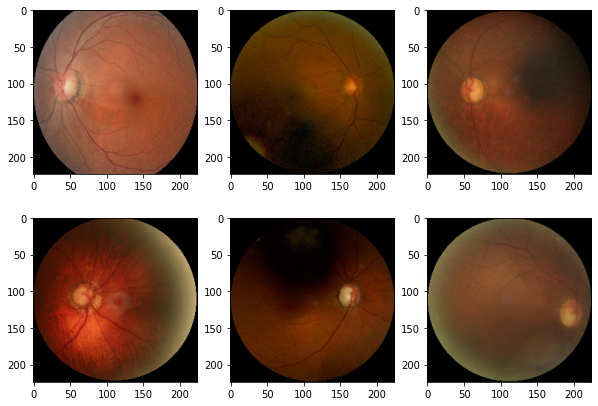

In [27]:
# Show regular images
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(10,7))
ax1.imshow(X_subset[0])
ax2.imshow(X_subset[1].astype('uint8'))
ax3.imshow(X_subset[2].astype('uint8'))
ax4.imshow(X_subset[3].astype('uint8'))
ax5.imshow(X_subset[4].astype('uint8'))
ax6.imshow(X_subset[5].astype('uint8'))

In [28]:
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),

    # 2. Affine (transformations)
    iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
               rotate=(-30, 30),
               scale=(0.5, 1.3)),

    # 3. Multiply (multiplies channels, makes images brighter or darker)
    iaa.Multiply((0.8, 1.2)),

    # # 4. Linearcontrast
    # iaa.LinearContrast((0.6, 1.4)),

    # Perform methods below only sometimes
    iaa.Sometimes(0.15,
        # 5. GaussianBlur
        iaa.GaussianBlur((0.0, 2.0)))
    
], random_order=True)

augmented_images = augmentation(images=X_subset[0:6])

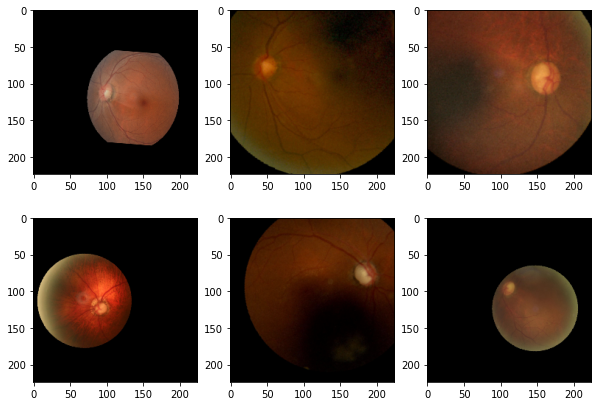

In [29]:
# Show augmented images
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(10,7))
ax1.imshow(augmented_images[0])
ax2.imshow(augmented_images[1].astype('uint8'))
ax3.imshow(augmented_images[2].astype('uint8'))
ax4.imshow(augmented_images[3].astype('uint8'))
ax5.imshow(augmented_images[4].astype('uint8'))
ax6.imshow(augmented_images[5].astype('uint8'))

In [30]:
final_augmented_array = pf.augment_one_class(X_subset, augmentation_method=augmentation, num_total_images=4000)
final_augmented_array.shape

(4000, 224, 224, 3)

In [31]:
"""Save array as .NPZ, takes 4 minutes"""
np.savez_compressed(filename, arr=final_augmented_array)

In [32]:
stop

NameError: name 'stop' is not defined

In [ ]:
disease_vectors = [[normal], [diabetes], [glaucoma], [cataracts], [amd], [hypertension], [myopia], [other]]
classes = [['N'], ['D'], ['G'], ['C'], ['A'], ['H'], ['M'], ['O']]

#### Test

In [ ]:
# Extract single diagnoses from test
X_set = []
y_set = []

for disease, cls in zip(disease_vectors, classes):
    X_subset, y_subset = pf.create_subsets(disease, cls, y_test, df, X_test)
    X_set.append(X_subset)
    y_set.append(y_subset)

# Get counts of each diagnosis
y_shapes = []

for i in range(len(X_set)):
    y_shapes.append(y_set[i].shape)

num_samples = []

for tuples in y_shapes:
    num_samples.append(tuples[0])

num_samples

[1 0 0 0 0 0 0 0] N


100%|██████████| 377/377 [00:00<00:00, 377207.21it/s]


[0 1 0 0 0 0 0 0] D


100%|██████████| 199/199 [00:00<?, ?it/s]


[0 0 1 0 0 0 0 0] G


100%|██████████| 29/29 [00:00<?, ?it/s]


[0 0 0 1 0 0 0 0] C


100%|██████████| 43/43 [00:00<?, ?it/s]


[0 0 0 0 1 0 0 0] A


100%|██████████| 37/37 [00:00<?, ?it/s]


[0 0 0 0 0 1 0 0] H


100%|██████████| 22/22 [00:00<00:00, 22022.60it/s]


[0 0 0 0 0 0 1 0] M


100%|██████████| 38/38 [00:00<?, ?it/s]


[0 0 0 0 0 0 0 1] O


100%|██████████| 117/117 [00:00<?, ?it/s]


[377, 199, 29, 43, 37, 22, 38, 117]

In [ ]:
# Make test set
X_set = []
y_set = []

for disease, cls in zip(disease_vectors, classes):
    X_subset, y_subset = pf.create_subsets(disease, cls, y_test, df, X_test)
    for sample in X_subset:
        X_set.append(sample)

X_set = np.array([X_set])
X_set = X_set.reshape(X_set.shape[0] * X_set.shape[1], X_set.shape[2], X_set.shape[3], X_set.shape[4])
X_set.shape

[1 0 0 0 0 0 0 0] N


100%|██████████| 377/377 [00:00<?, ?it/s]


[0 1 0 0 0 0 0 0] D


100%|██████████| 199/199 [00:00<?, ?it/s]


[0 0 1 0 0 0 0 0] G


100%|██████████| 29/29 [00:00<?, ?it/s]


[0 0 0 1 0 0 0 0] C


100%|██████████| 43/43 [00:00<?, ?it/s]


[0 0 0 0 1 0 0 0] A


100%|██████████| 37/37 [00:00<?, ?it/s]


[0 0 0 0 0 1 0 0] H


100%|██████████| 22/22 [00:00<?, ?it/s]


[0 0 0 0 0 0 1 0] M


100%|██████████| 38/38 [00:00<?, ?it/s]


[0 0 0 0 0 0 0 1] O


100%|██████████| 117/117 [00:00<?, ?it/s]


(862, 224, 224, 3)

In [ ]:
# Make labels
final_labels = []
for num, vector in zip(num_samples, disease_vectors):
    for i in range(num):
        final_labels.append(vector[0])

final_labels = np.array([final_labels])
final_labels = final_labels.reshape(final_labels.shape[0] * final_labels.shape[1], final_labels.shape[2])
final_labels.shape

(862, 8)

In [ ]:
final_labels[:,0].sum()

377

In [ ]:
X, y = shuffle(X_set, final_labels, random_state=42)

In [ ]:
"""Save array as .NPZ, takes 4 minutes""" #update
np.savez_compressed('Test_set_X_GaussNoContrast', arr=X)
np.savez_compressed('Test_set_y_GaussNoContrast', arr=y)

#### Val

In [ ]:
# Extract single diagnoses from val
X_set = []
y_set = []

for disease, cls in zip(disease_vectors, classes):
    X_subset, y_subset = pf.create_subsets(disease, cls, y_val, df, X_val)
    X_set.append(X_subset)
    y_set.append(y_subset)

# Get counts of each diagnosis
y_shapes = []

for i in range(len(X_set)):
    y_shapes.append(y_set[i].shape)

num_samples = []

for tuples in y_shapes:
    num_samples.append(tuples[0])

num_samples

[1 0 0 0 0 0 0 0] N


100%|██████████| 400/400 [00:00<?, ?it/s]


[0 1 0 0 0 0 0 0] D


100%|██████████| 192/192 [00:00<?, ?it/s]


[0 0 1 0 0 0 0 0] G


100%|██████████| 27/27 [00:00<?, ?it/s]


[0 0 0 1 0 0 0 0] C


100%|██████████| 44/44 [00:00<?, ?it/s]


[0 0 0 0 1 0 0 0] A


100%|██████████| 24/24 [00:00<?, ?it/s]


[0 0 0 0 0 1 0 0] H


100%|██████████| 11/11 [00:00<?, ?it/s]


[0 0 0 0 0 0 1 0] M


100%|██████████| 33/33 [00:00<?, ?it/s]


[0 0 0 0 0 0 0 1] O


100%|██████████| 143/143 [00:00<?, ?it/s]


[400, 192, 27, 44, 24, 11, 33, 143]

In [ ]:
# Make val set
X_set = []
y_set = []

for disease, cls in zip(disease_vectors, classes):
    X_subset, y_subset = pf.create_subsets(disease, cls, y_val, df, X_val)
    for sample in X_subset:
        X_set.append(sample)

X_set = np.array([X_set])
X_set = X_set.reshape(X_set.shape[0] * X_set.shape[1], X_set.shape[2], X_set.shape[3], X_set.shape[4])
X_set.shape

[1 0 0 0 0 0 0 0] N


100%|██████████| 400/400 [00:00<?, ?it/s]


[0 1 0 0 0 0 0 0] D


100%|██████████| 192/192 [00:00<?, ?it/s]


[0 0 1 0 0 0 0 0] G


100%|██████████| 27/27 [00:00<?, ?it/s]


[0 0 0 1 0 0 0 0] C


100%|██████████| 44/44 [00:00<?, ?it/s]


[0 0 0 0 1 0 0 0] A


100%|██████████| 24/24 [00:00<?, ?it/s]


[0 0 0 0 0 1 0 0] H


100%|██████████| 11/11 [00:00<?, ?it/s]


[0 0 0 0 0 0 1 0] M


100%|██████████| 33/33 [00:00<?, ?it/s]


[0 0 0 0 0 0 0 1] O


100%|██████████| 143/143 [00:00<?, ?it/s]


(874, 224, 224, 3)

In [ ]:
# Make labels
final_labels = []
for num, vector in zip(num_samples, disease_vectors):
    for i in range(num):
        final_labels.append(vector[0])

final_labels = np.array([final_labels])
final_labels = final_labels.reshape(final_labels.shape[0] * final_labels.shape[1], final_labels.shape[2])
final_labels.shape

(874, 8)

In [ ]:
final_labels[:,0].sum()

400

In [ ]:
X, y = shuffle(X_set, final_labels, random_state=42)

In [ ]:
"""Save array as .NPZ, takes 4 minutes""" # update
np.savez_compressed('Val_set_X_GaussNoContrast', arr=X)
np.savez_compressed('Val_set_y_GaussNoContrast', arr=y)

In [ ]:
stop

NameError: name 'stop' is not defined

## Pixel Norm After Aug

In [ ]:
# Load array, takes 40 seconds
# _no_background.npz works better because it doesn't yield weird green contrasts after augmentation
loaded = np.load('Augmented Images\RawAugImg_hypertension.npz')
X = loaded.f.arr
print(X.shape)
print(np.amax(X[1]))

FileNotFoundError: [Errno 2] No such file or directory: 'Augmented Images\\RawAugImg_hypertension.npz'

In [ ]:
X_dataset = []
    
for img in tqdm(X):
    img = img/255
    X_dataset.append(img)

X = np.array(X_dataset)
np.amax(X[1])

100%|██████████| 5000/5000 [00:03<00:00, 1256.21it/s]


0.8627450980392157

In [ ]:
"""Save array as .NPZ, takes 4 minutes"""
np.savez_compressed("PixNorm_AugImg_hypertension", arr=X)

In [ ]:
stop

NameError: name 'stop' is not defined

## Section 1.2 - Image Processing

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Activation, BatchNormalization
import matplotlib.pyplot as plt

### Section 1.2.2 - Visualize Different Processing Methods

#### Raw

100%|██████████| 5/5 [00:00<00:00, 42.37it/s]


(5, 224, 224, 3)


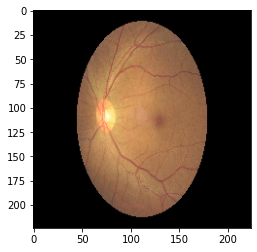

In [ ]:
# Create array of 5 raw images
X_example = pf.image_to_array_raw(image_filepaths[0:5], img_size)
print(X_example.shape)

# Show non-normalized image with .astype('uint8')
plt.imshow(X_example[1].astype('uint8'))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


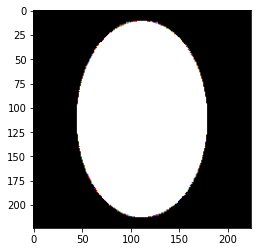

In [ ]:
# Show non-normalized image with no .astype('uint8')
plt.imshow(X_example[1])
plt.show()

#### Normalized /255

100%|██████████| 5/5 [00:00<00:00, 43.10it/s]


(5, 224, 224, 3)


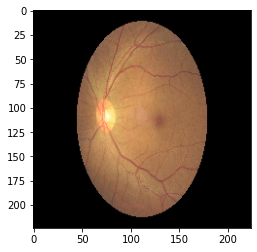

In [ ]:
# Create array of 5 pixel normalized images
X_example = pf.image_to_array_norm_pix(image_filepaths[0:5], img_size)
print(X_example.shape)

# Show non-normalized image, .astype('uint8') not needed
plt.imshow(X_example[1])
plt.show()

In [ ]:
np.amax(X_example[1])

1.0

#### PreResNet50

100%|██████████| 5/5 [00:00<00:00, 48.48it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(5, 224, 224, 3)


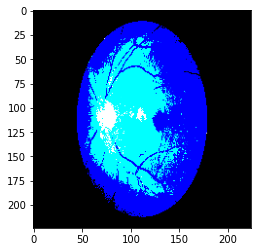

In [ ]:
# Create array of 5 pixel normalized images
X_example = pf.image_to_array_preresnet50(image_filepaths[0:5], img_size)
print(X_example.shape)

# Show resnet processing .astype('uint8')
plt.imshow(X_example[1])
plt.show()

#### No Background

In [ ]:
# Check channel modes of all images

rgbImage = Image.open('Images/' + image_filepaths[1])
print(rgbImage.mode)

RGB


Image name:	 Images\1_left.jpg
Original (raw) image:	 (2304, 3456, 3)


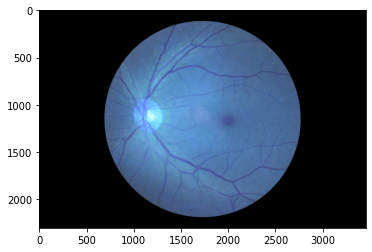

In [ ]:
# Function test:
image_path = os.path.join('Images', image_filepaths[1])
image = cv.imread(image_path)
print(f"Image name:\t {image_path}")
print('Original (raw) image:\t', image.shape)
plt.imshow(image)
plt.show()

Preprocessed image:	 (224, 224, 3)


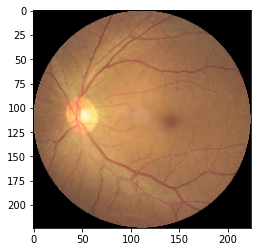

In [ ]:
image_prepped = pf.load_prep_img(image_path)
print('Preprocessed image:\t', image_prepped.shape)
plt.imshow(image_prepped)
plt.show()

### Section 1.2.3 - Save/Load Image Arrays

In [ ]:
## Convert images to array
# X = image_to_array_raw(image_filepaths, img_size)
# X.shape

In [ ]:
"""Save array as .NPZ, takes 4 minutes"""
# np.savez_compressed('ImagesToArrays_9300_224_raw', arr=X)

'Save array as .NPZ, takes 4 minutes'

In [ ]:
# Load array, takes 40 seconds
loaded = np.load('ImagesToArrays_9300_224_no_background.npz')
X_loaded = loaded.f.arr
X_example = X_loaded[0:10]
del X_loaded
X_example.shape

KeyboardInterrupt: 

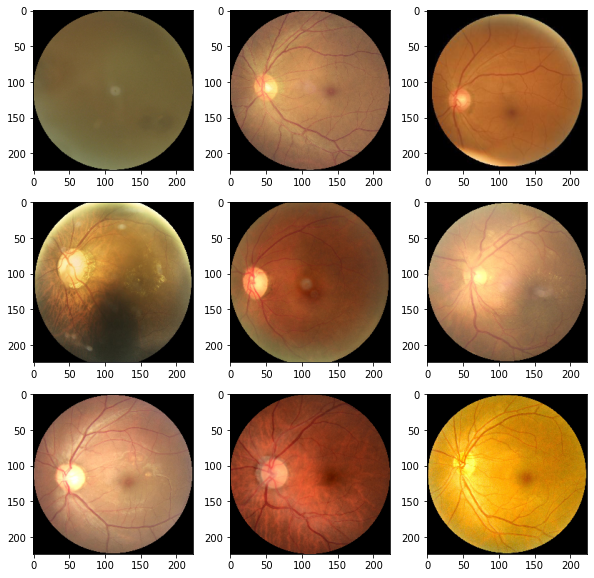

In [ ]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3,3, figsize=(10,10))
ax1.imshow(X[0])
ax2.imshow(X[1])
ax3.imshow(X[2])
ax4.imshow(X[3])
ax5.imshow(X[4])
ax6.imshow(X[5])
ax7.imshow(X[6])
ax8.imshow(X[7])
ax9.imshow(X[8])

### Section 1.2.4 - CLAHE 

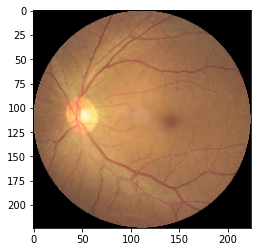

In [ ]:
# normal image
plt.imshow(image_prepped)
plt.show()

#### HSV

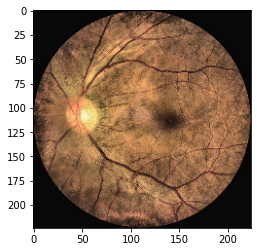

In [ ]:
rgb_hsv = pf.apply_clahe_hsv(image_prepped, clip=7.0, grid_size=(8,8))
plt.imshow(rgb_hsv)
plt.show()

#### LAB

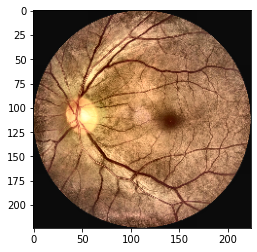

In [ ]:
# cliplimit = 7, grid_size = 8
rgb_lab = pf.apply_clahe_lab(image_prepped, clip=7.0, grid_size=(8,8))
plt.imshow(rgb_lab)
plt.show()

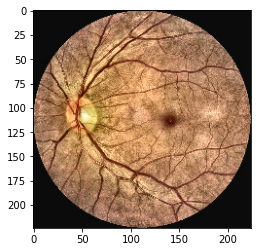

In [ ]:
# cliplimit = 7, grid_size = 16
rgb_lab = pf.apply_clahe_lab(image_prepped, clip=7.0, grid_size=(16,16))
plt.imshow(rgb_lab)
plt.show()

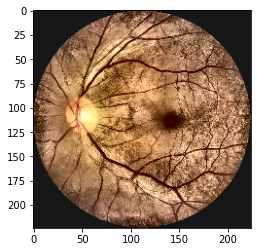

In [ ]:
# cliplimit = 20, grid_size = 8
rgb_lab = pf.apply_clahe_lab(image_prepped, clip=20.0, grid_size=(8,8))
plt.imshow(rgb_lab)
plt.show()

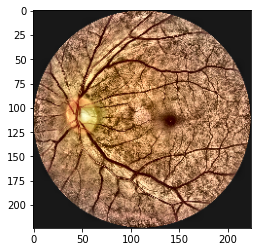

In [ ]:
# cliplimit = 20, grid_size = 16
rgb_lab = pf.apply_clahe_lab(image_prepped, clip=20.0, grid_size=(16,16))
plt.imshow(rgb_lab)
plt.show()

#### Separate RGB

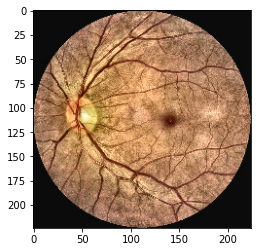

In [ ]:
rgb = pf.apply_clahe_lab(image_prepped, clip=7.0, grid_size=(16,16))
plt.imshow(rgb)
plt.show()

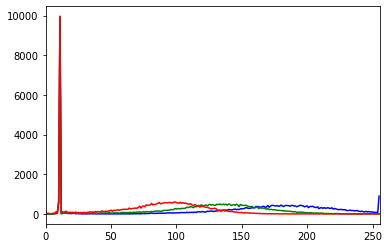

In [ ]:
color = ('b','g','r')
for i,col in enumerate(color):
    histr, _ = np.histogram(rgb[:,:,i],256,[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

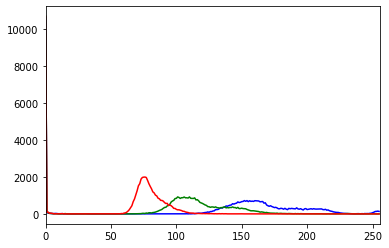

In [ ]:
color = ('b','g','r')
for i,col in enumerate(color):
    histr, _ = np.histogram(image_prepped[:,:,i],256,[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

#### Green Channel

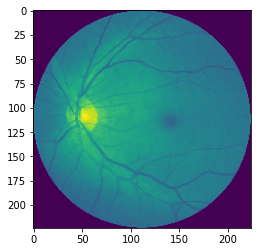

In [ ]:
# regular green channel
plt.imshow(image_prepped[:,:,1])
plt.show()

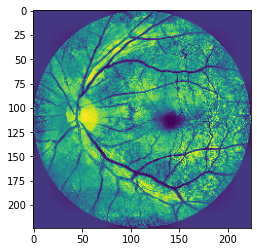

In [ ]:
# green channel, climit = 40, grid_size=8
g = pf.apply_green_CLAHE(image_prepped, clip=40.0, grid_size=(8,8))
plt.imshow(g)
plt.show()

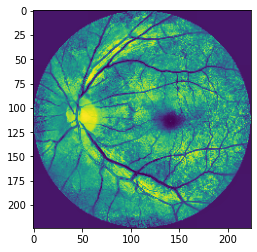

In [ ]:
# green channel, climit = 15, grid_size=8
g = pf.apply_green_CLAHE(image_prepped, clip=15.0, grid_size=(8,8))
plt.imshow(g)
plt.show()

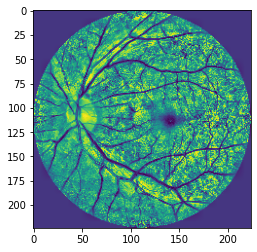

In [ ]:
# green channel, climit = 40, grid_size=16
g = pf.apply_green_CLAHE(image_prepped, clip=40.0, grid_size=(16,16))
plt.imshow(g)
plt.show()

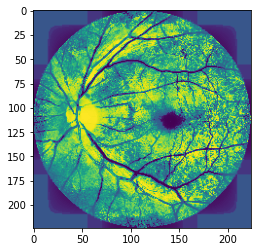

In [ ]:
# green channel, climit = 40, grid_size=8, + HE
equalized = pf.apply_green_channel(image_prepped, clip=40.0, grid_size=(8,8), filtering=False)
plt.imshow(equalized)
plt.show()

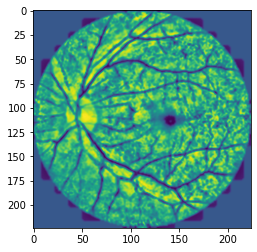

In [ ]:
# green channel, climit = 40, grid_size=8, + HE + Gaussian
equalized = pf.apply_green_channel(image_prepped, clip=40.0, grid_size=(16,16))
plt.imshow(equalized)
plt.show()

#### CLAHE vs Non-CLAHE

100%|██████████| 6/6 [00:00<00:00, 461.54it/s]

(6, 224, 224, 3)


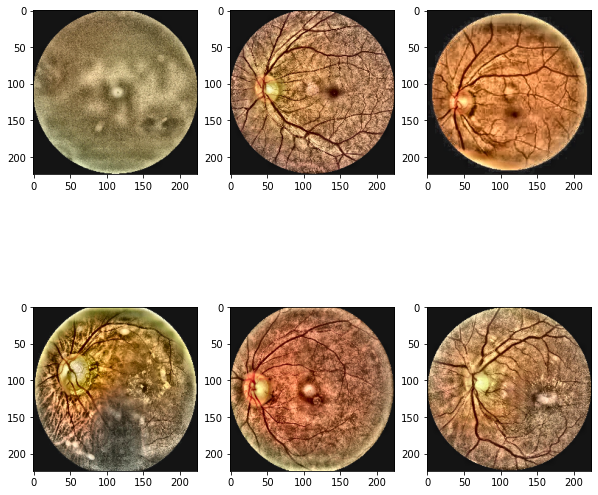

In [ ]:
# Apply LAB CLAHE
X_clahe = pf.apply_clahe_all(pf.apply_clahe_lab, X[0:6], clip=15.0, grid_size=(16,16), filtering=False)
print(X_clahe.shape)

# Plot
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(10,10))
ax1.imshow(X_clahe[0])
ax2.imshow(X_clahe[1])
ax3.imshow(X_clahe[2])
ax4.imshow(X_clahe[3])
ax5.imshow(X_clahe[4])
ax6.imshow(X_clahe[5])

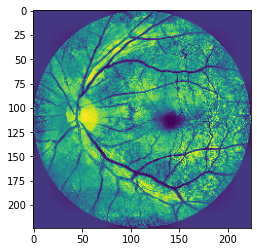

In [ ]:
g = pf.apply_green_CLAHE(image_prepped, clip=40.0, grid_size=(8,8))
plt.imshow(g)
plt.show()

100%|██████████| 6/6 [00:00<00:00, 3011.35it/s]

(6, 224, 224)


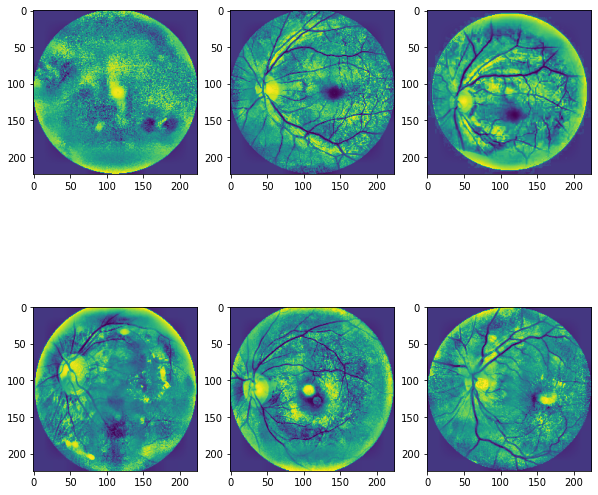

In [ ]:
# Apply green channel with no filtering
X_clahe = pf.apply_clahe_all(pf.apply_green_CLAHE, X[0:6], clip=40.0, grid_size=(8,8), filtering=False)
print(X_clahe.shape)

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(10,10))
ax1.imshow(X_clahe[0])
ax2.imshow(X_clahe[1])
ax3.imshow(X_clahe[2])
ax4.imshow(X_clahe[3])
ax5.imshow(X_clahe[4])
ax6.imshow(X_clahe[5])

100%|██████████| 6/6 [00:00<00:00, 2000.30it/s]

(6, 224, 224)


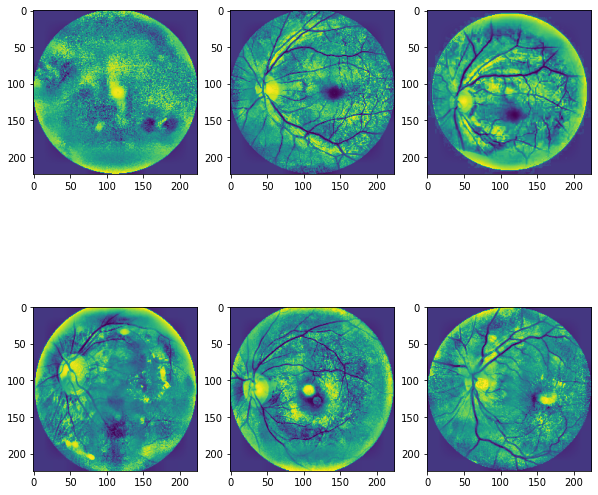

In [ ]:
# Apply green channel with no filtering
X_clahe = pf.apply_clahe_all(pf.apply_green_CLAHE, X[0:6], clip=40.0, grid_size=(8,8), filtering=False)
print(X_clahe.shape)

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(10,10))
ax1.imshow(X_clahe[0])
ax2.imshow(X_clahe[1])
ax3.imshow(X_clahe[2])
ax4.imshow(X_clahe[3])
ax5.imshow(X_clahe[4])
ax6.imshow(X_clahe[5])

100%|██████████| 6/6 [00:00<00:00, 1201.18it/s]


(6, 224, 224)


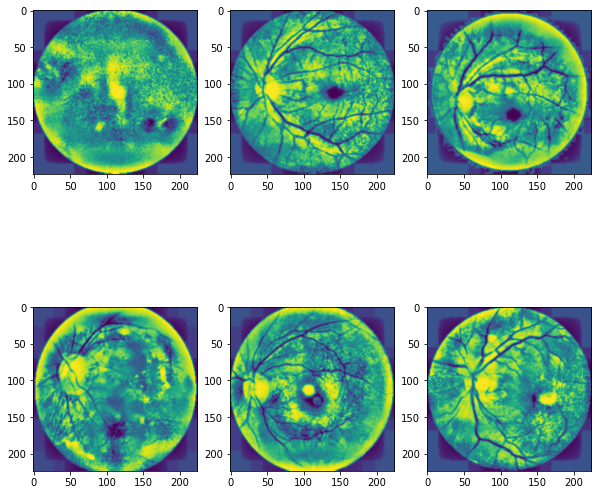

In [ ]:
# Apply green channel with filtering
X_clahe = pf.apply_clahe_all(pf.apply_green_channel, X[0:6], clip=40.0, grid_size=(8,8), filtering=True)
print(X_clahe.shape)

#Plot
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(10,10))
ax1.imshow(X_clahe[0])
ax2.imshow(X_clahe[1])
ax3.imshow(X_clahe[2])
ax4.imshow(X_clahe[3])
ax5.imshow(X_clahe[4])
ax6.imshow(X_clahe[5])

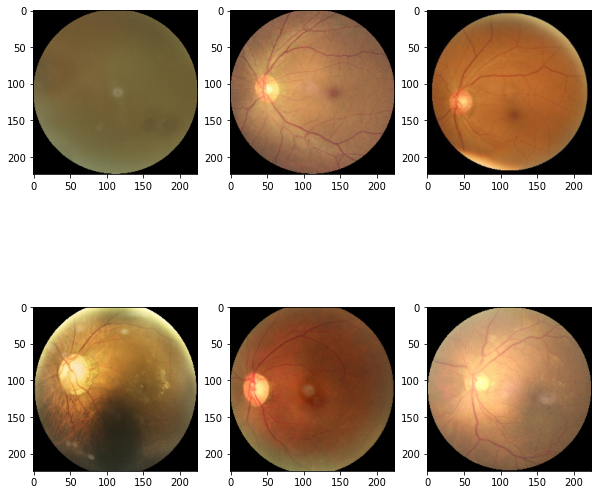

In [ ]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(10,10))
ax1.imshow(X[0])
ax2.imshow(X[1])
ax3.imshow(X[2])
ax4.imshow(X[3])
ax5.imshow(X[4])
ax6.imshow(X[5])

In [ ]:
# fig = plt.figure()
# for i in range(len(X[0:6])):
#     ax = ax.imshow(X[i])
#     ax.title.set_text(df['Diagnostic_Keywords'][i])

# plt.show()

In [ ]:
df['Diagnostic_Keywords'][0]

'cataract'

In [ ]:
df.head(6)

Patient Age Patient Sex  Image_Name  \
0           69      Female  0_left.jpg   
1           57        Male  1_left.jpg   
2           66        Male  3_left.jpg   
3           53        Male  4_left.jpg   
4           50      Female  5_left.jpg   
5           60        Male  6_left.jpg   

                      Diagnostic_Keywords  N  D  G  C  A  H  M  O  
0                                cataract  0  0  0  1  0  0  0  0  
1                           normal fundus  1  0  0  0  0  0  0  0  
2                           normal fundus  1  0  0  0  0  0  0  0  
3             macular epiretinal membrane  0  0  0  0  0  0  0  1  
4  moderate non proliferative retinopathy  0  1  0  0  0  0  0  0  
5             macular epiretinal membrane  0  0  0  0  0  0  0  1

#### Apply CLAHE and Save

In [ ]:
# X_clahe = pf.apply_clahe_all(pf.apply_green_CLAHE, X, clip=40.0, grid_size=(8,8), filtering=False)
# X_clahe.shape

In [ ]:
"""Save array as .NPZ, takes 4 minutes"""
# np.savez_compressed('CLAHE_Green_9300_224_40-8-NoGauss', arr=X_clahe)
# del X

'Save array as .NPZ, takes 4 minutes'

In [ ]:
# loaded = np.load('CLAHE_Green_9300_224_40-8-NoGauss.npz')
# X = loaded.f.arr
# X.shape

In [ ]:
del X
# Load array, takes 40 seconds
loaded = np.load('CLAHE_Green_9300_224_40-8-NoGauss.npz')
X = loaded.f.arr
X.shape

(9300, 224, 224)

### Section 1.2.5 - ORB Fx Extraction

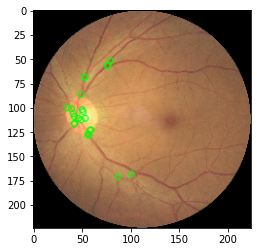

(<matplotlib.image.AxesImage at 0x1a4ef3a8130>, None)

In [ ]:
## Normal image + ORB

# Initiate ORB detector
orb = cv.ORB_create()

# find the keypoints with ORB
kp = orb.detect(image_prepped, None)

# compute the descriptors with ORB
kp, des = orb.compute(image_prepped, kp)

# draw only keypoints location,not size and orientation
img2 = cv.drawKeypoints(image_prepped, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2), plt.show()

In [ ]:
# X = pf.apply_orb(X)
# X.shape

In [ ]:
# Check that all entries have the same dimensions
for i in range(len(X)):
    if X[i].shape != (200, 32):
        print(i)
        print(X[i].shape)

0
(224, 224)
1
(224, 224)
2
(224, 224)
3
(224, 224)
4
(224, 224)
5
(224, 224)
6
(224, 224)
7
(224, 224)
8
(224, 224)
9
(224, 224)
10
(224, 224)
11
(224, 224)
12
(224, 224)
13
(224, 224)
14
(224, 224)
15
(224, 224)
16
(224, 224)
17
(224, 224)
18
(224, 224)
19
(224, 224)
20
(224, 224)
21
(224, 224)
22
(224, 224)
23
(224, 224)
24
(224, 224)
25
(224, 224)
26
(224, 224)
27
(224, 224)
28
(224, 224)
29
(224, 224)
30
(224, 224)
31
(224, 224)
32
(224, 224)
33
(224, 224)
34
(224, 224)
35
(224, 224)
36
(224, 224)
37
(224, 224)
38
(224, 224)
39
(224, 224)
40
(224, 224)
41
(224, 224)
42
(224, 224)
43
(224, 224)
44
(224, 224)
45
(224, 224)
46
(224, 224)
47
(224, 224)
48
(224, 224)
49
(224, 224)
50
(224, 224)
51
(224, 224)
52
(224, 224)
53
(224, 224)
54
(224, 224)
55
(224, 224)
56
(224, 224)
57
(224, 224)
58
(224, 224)
59
(224, 224)
60
(224, 224)
61
(224, 224)
62
(224, 224)
63
(224, 224)
64
(224, 224)
65
(224, 224)
66
(224, 224)
67
(224, 224)
68
(224, 224)
69
(224, 224)
70
(224, 224)
71
(224, 224)
72

In [ ]:
# for x in range(len(X_descriptors)):
#     print(X_descriptors[x].shape)
#     print(X_descriptors[x])

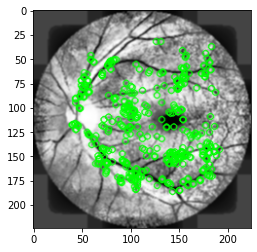

(<matplotlib.image.AxesImage at 0x1a4ef518eb0>, None)

In [ ]:
## Green Channel CLAHE + ORB

# Initiate ORB detector
orb = cv.ORB_create(nfeatures=500)

# find the keypoints with ORB
kp = orb.detect(X_clahe[1], None)

# compute the descriptors with ORB
kp, des = orb.compute(X_clahe[1], kp)

# draw only keypoints location,not size and orientation
img2 = cv.drawKeypoints(X_clahe[1], kp, None, color=(0,255,0), flags=0)
plt.imshow(img2), plt.show()

In [ ]:
des.ndim

2

In [ ]:
print(des[0])
print(des[0].shape)

[ 10 178 188 245 111 121  49 186  15  63  20  50  76 255 200 175 135  91
 167  32 162 124 187 209  79 211 117 255 150 232   5 235]
(32,)


In [ ]:
des.shape

(435, 32)

In [ ]:
kp[0]

<KeyPoint 000001A4F26984E0>

In [ ]:
i = 0 
for k in kp:
    i += 1

print(i)

435


### Section 1.2.6 - Subset Creation

In [ ]:
# Make df of selected diseases - update
selected_diseases_df = df[['N', 'H']]
selected_diseases_list = [normal, hypertension]

In [ ]:
desired_indices_list = pf.find_desired_indices(labels, selected_diseases_list)

len(desired_indices_list)

4136

In [ ]:
# Create array of labels with the desired diseases
selected_labels = selected_diseases_df.values
print(selected_labels.shape)

(9300, 2)


In [ ]:
X_subset = pf.create_data_subset(desired_indices_list, X)
X_subset.shape

100%|██████████| 4136/4136 [00:00<00:00, 1196389.06it/s]


(4136, 200, 32)

In [ ]:
y_subset = pf.create_subset_labels(desired_indices_list, selected_labels)
print(y_subset.shape)
print(y_subset[0:5])
print(y_subset[:, 0].sum())
print(y_subset[:, 1].sum())

print(y_subset[:, 0].sum() + y_subset[:, 1].sum())

100%|██████████| 4136/4136 [00:00<00:00, 584449.88it/s]

(4136, 2)
[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]
3994
142
4136


In [ ]:
X_subset.shape

(4136, 200, 32)

In [ ]:
# Update
# X must be (# samples, # of features) for Naive Bayes, so re-shape
X_subset = X_subset.reshape(X_subset.shape[0], X_subset.shape[1] * X_subset.shape[2])

print(X_subset.shape)

(4136, 6400)


In [ ]:
new_y_subset = []

for y in y_subset:
    # Check if normal
    if np.array_equal(np.array([1, 0]), y):
        new_y = 1
        new_y_subset.append(new_y)
    else:
        new_y = 0
        new_y_subset.append(new_y)

len(new_y_subset)

4136

In [ ]:
# Check number of normal (should be 3994)
print(sum(new_y_subset))

# Check number of diseases, count zeros
new_y_subset.count(0)

3994


142

In [ ]:
y_subset = np.array(new_y_subset)
# del new_y_subset

In [ ]:
y_subset[0:5]

array([1, 1, 1, 1, 1])

In [ ]:
normal_idxs = []

# If normal, add index to list
for idx in range(len(y_subset)):
    if y_subset[idx] == 1:
        normal_idxs.append(idx)

print(len(normal_idxs))

3994


In [ ]:
disease_idxs = []

# If disease, add index to list
for idx in range(len(y_subset)):
    if y_subset[idx] == 0:
        disease_idxs.append(idx)

print(len(disease_idxs))

142


In [ ]:
X_subset[0].shape

(6400,)

In [ ]:
X_subset.shape

(4136, 6400)

In [ ]:
# Create balanced subset, equal normal and equal disease
X_subset_balanced = []

# add normal and disease to new subset
for idx in normal_idxs[0:new_y_subset.count(0)]:
    X_subset_balanced.append(X_subset[idx])

for idx in disease_idxs[0:new_y_subset.count(0)]:
    X_subset_balanced.append(X_subset[idx])

len(X_subset_balanced)        

284

In [ ]:
X_subset = np.array(X_subset_balanced)
X_subset.shape

(284, 6400)

In [ ]:
y_subset_list = []

# Add normal labels
for i in range(new_y_subset.count(0)):
    y_subset_list.append(1)

# Add disease labels
for i in range(new_y_subset.count(0)):
    y_subset_list.append(0)

y_subset = np.array(y_subset_list)

y_subset.shape

(284,)

In [ ]:
# Split training, validation, and test sets, takes 42 seconds
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, random_state = 20, test_size = 0.3)

#X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, random_state = 20, test_size = 0.5)

In [ ]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

# print(X_val.shape)
# print(y_val.shape)

(198, 6400)
(198,)
(86, 6400)
(86,)


In [ ]:
# Delete X to free up RAM
del X

In [ ]:
go to 2.4

SyntaxError: invalid syntax (<ipython-input-109-04936e2d3e12>, line 1)

### Section 1.2.5 - ImageGenerator

In [ ]:
# from keras_preprocessing.image import ImageDataGenerator

In [ ]:
# classes = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

# my_generator = ImageDataGenerator(
#     rescale=1./255
#     )

# img_iter = my_generator.flow_from_dataframe(
#     df,
#     directory='Images',
#     x_col='Image_Name',
#     y_col=classes,
#     class_mode='other',
#     target_size=(img_size, img_size), 
#     batch_size=32
# )

Found 9300 validated image filenames.


In [ ]:
# X = next(iter(img_iter))
# print(X[0].shape)

(2, 224, 224, 3)


In [ ]:
# print(X[1].shape)

(2, 8)


In [ ]:
# type(X[1])

numpy.ndarray

# Section 2 - Models

In [ ]:
def plot_model_metrics(metrics_dict):
    metrics_names_list = list(metrics_dict.keys())
    epochs = range(1, len(metrics_dict['loss']) + 1)

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    fig.suptitle("Model Metrics", fontsize=18, y=0.95)

    for metric, ax in zip(metrics_names_list[0:4], axs.ravel()):
        val_idx = metrics_names_list.index(metric) + 4
        val_metric = metrics_names_list[val_idx]

        ax.plot(epochs, metrics_dict[metric], 'b', label= "Training " + metric)
        ax.plot(epochs, metrics_dict[val_metric], 'r', label= "Val " + metric)

        if metric == 'loss':
            ax.set_ylim(0, 2)
        else:
            ax.set_ylim(0.5, 1)

        ax.legend()

        # chart formatting
        ax.set_title(metric.capitalize())

    plt.show()

In [ ]:
input_size = X_train.shape[1:]
metrics = ['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
num_classes = y_train.shape[1]
loss = 'binary_crossentropy'
opt = keras.optimizers.Adam(learning_rate = 0.01) 
pretrained_weights = 'imagenet'
pooling = 'avg'
epochs = 15

## Section 2.1 - Resnet50 TL

In [ ]:
my_resnet50 = Sequential()
 
pre_trainined_resnet50 = keras.applications.ResNet50(include_top=False,
                                                    input_shape=input_size,
                                                    pooling=pooling,
                                                    classes=num_classes,
                                                    weights=pretrained_weights
                                                    )

for layer in pre_trainined_resnet50.layers:
    layer.trainable = False

my_resnet50.add(pre_trainined_resnet50)
my_resnet50.add(Flatten())
my_resnet50.add(Dense(512, activation='relu'))
my_resnet50.add(Dense(num_classes, activation='sigmoid'))

my_resnet50.compile(
    optimizer = opt,
    loss = loss,
    metrics = metrics
    )

my_resnet50.summary()

In [ ]:
history_my_resnet50 = my_resnet50.fit(
                    X_train, 
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    use_multiprocessing=True
                    )

In [ ]:
test_results_dict = my_resnet50.evaluate(X_test, y_test, verbose=1, return_dict=True)
test_results_dict

In [ ]:
plot_model_metrics(history_my_resnet50.history)

## Section 2.2 - Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn

In [ ]:
clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB()

In [ ]:
y_test.shape

(86,)

In [ ]:
y_preds = clf.predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
       % (X_test.shape[0], (y_test != y_preds).sum()))

Number of mislabeled points out of a total 86 points : 53


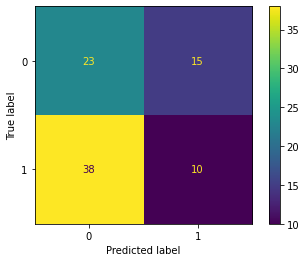

In [ ]:
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

<AxesSubplot:>

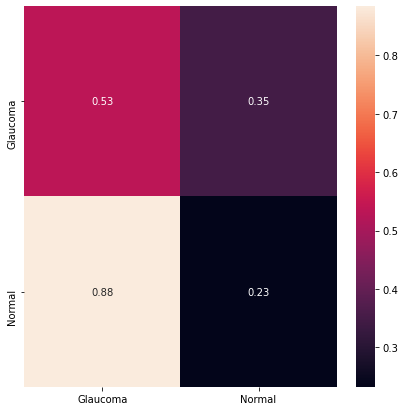

In [ ]:
# Create confusion matrix
"""Code adapted from: # https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7 """

classes = ('Glaucoma', 'Normal')

cf_matrix = confusion_matrix(y_test, y_preds)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * len(classes), index = [i for i in classes],
                     columns = [i for i in classes])

plt.figure(figsize = (7,7))
sn.heatmap(df_cm, annot=True)